In [1]:
import sys
sys.path.append("..")
from tqdm.notebook import tqdm
import numpy as np
from mango.environments import frozen_lake
import utils_plot, utils_save, utils_sim

In [2]:
# parameters for the environment
map_scale = 2
p_frozen = 0.8
use_mango = True

# parameters for the training
N_episodes =  10000
train_steps_per_episode = 10
episode_length = (4**map_scale)

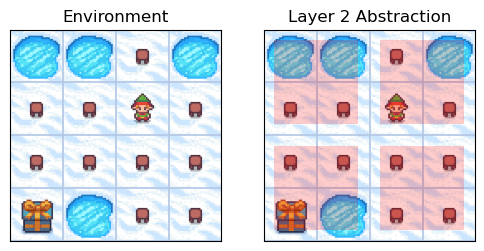

In [3]:
# create the environment and the option manager
env = utils_sim.make_env(map_scale, p_frozen, start_anywhere=True)
option_manager = utils_sim.make_option_manager(env, map_scale)
if use_mango:
    frozen_lake.plot_utils.plot_all_abstractions(option_manager)
    option_manager.set_randomness(0.0)
    option_manager.set_auto_train(True)
    environment = option_manager
else:
    environment = option_manager.environment
agent = utils_sim.make_agent(environment, map_scale)

In [4]:
# small initial train loop to stabilize mango
if use_mango:
    for layer_idx, layer in enumerate(option_manager.abstract_layers, start=1):
        for iteration, randomness in enumerate(tqdm(np.linspace(1, 0, N_episodes//10))):
            layer.set_randomness(randomness)
            reward, info = layer.explore(episode_length)
            for _ in range(train_steps_per_episode):
                layer.train()
        layer.set_auto_train(True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# train loop
for iteration, randomness in enumerate(tqdm(np.linspace(1, 0, N_episodes))):
    randomness = 0.0 if iteration % 2 else randomness
    reward, info = agent.run_episode(randomness, episode_length)
    for _ in range(train_steps_per_episode):
        agent.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

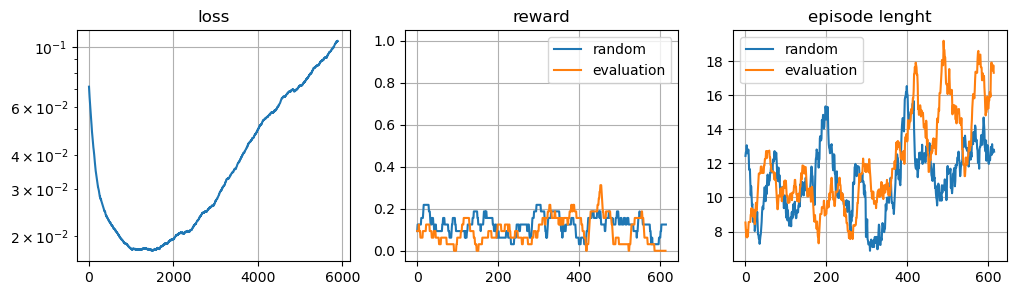

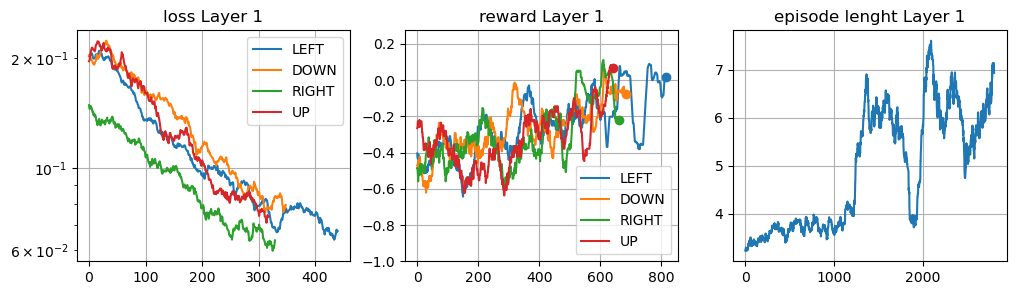

In [ ]:
name = "mango_agent" if use_mango else "normal_agent"
dir_path = utils_save.path_to_save_dir(map_scale, p_frozen)
utils_save.save_to_file(path=dir_path + f"/{name}.pickle", obj=agent)
utils_plot.plot_agent_loss_reward(agent, save_path=dir_path + f"/{name}_training.png")
if not use_mango:
    frozen_lake.plot_utils.plot_all_qvals_agent(agent, save_path=dir_path + f"/{name}_qvals.png")
else:
    utils_plot.plot_mango_loss_reward(option_manager, save_path=dir_path + f"/option_manager_training.png")
    utils_save.save_to_file(path=dir_path + f"/option_manager.pickle", obj=agent)
